# Homework 2 SUBMISSION

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

**Group A 24**
* Coleen Jin
* Jiachen Sun
* Josh Weekes

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import fsolve
from scipy.stats import norm

import sys

#sys.path.insert(0, '../cmds')
#from ficcvol import *
#from binomial import *
#from ratecurves import *
import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

# 1. Stripping Caps

The file `data/cap_curves_2024-02-16.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-0.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f_{\tau}$.

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$

## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [3]:
DATE = '2024-02-16'
curves = pd.read_excel(f'..\data\cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')
curves.head()

,swap rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,
0.25,0.053220,0.986870,NaN,NaN,NaN
0.50,0.052569,0.974225,0.051917,0.164498,0.164498
0.75,0.051547,0.962315,0.049503,0.189530,0.208622
1.00,0.050334,0.951210,0.046700,0.214562,0.251768
1.25,0.048626,0.941373,0.041799,0.257098,0.355909


In [3]:
def blacks_formula(T,vol,strike,fwd,discount=1,isCall=True):
        
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1-sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val


In [4]:
def cap_vol_to_price(flatvol, strike, fwds, discounts, dt=.25, notional=100):
    T = discounts.index[-1]
    flatvalues = pd.Series(dtype=float, index=discounts.index, name='flat values')
    
    tprev = discounts.index[0]
    for t in discounts.index[1:]:
        flatvalues.loc[t] = notional * dt * blacks_formula(tprev, flatvol, strike, fwds.loc[t], discounts.loc[t])
        tprev = t
        
    capvalue = flatvalues.sum()        
    return capvalue

In [5]:
def flat_to_forward_vol(curves, freq=None, notional=100):
    
    dt = curves.index[1] - curves.index[0]
    if freq is None:
        freq = int(1/dt)
   
    capcurves = curves[['flat vols']].copy()

    for tstep, t in enumerate(capcurves.index):
    
        if tstep == 0:
            capcurves.loc[t,'caplet prices'] = np.nan
            capcurves.loc[t,'fwd vols'] = np.nan
        else:
            capcurves.loc[t,'cap prices'] = cap_vol_to_price(capcurves.loc[t,'flat vols'], curves.loc[t,'swap rates'], curves.loc[:t,'forwards'], curves.loc[:t,'discounts'], dt=dt)
            capcurves['caplet prices'].loc[t] = capcurves.loc[t,'cap prices'] - capcurves.loc[:tprev,'caplet prices'].sum()
            wrapper = lambda vol: capcurves['caplet prices'].loc[t] - notional * (1/freq) * blacks_formula(tprev, vol, curves.loc[t,'swap rates'], curves.loc[t,'forwards'], curves.loc[t,'discounts'])
            capcurves.loc[t,'fwd vols'] = fsolve(wrapper,capcurves.loc[t,'flat vols'])[0]

        tprev = t
        
    return capcurves


In [6]:
capcurves = flat_to_forward_vol(curves)
# compute the cap prices
capcurves[['cap prices']]

,cap prices
tenor,
0.25,NaN
0.50,0.034285
0.75,0.095557
1.00,0.186823
1.25,0.333136
1.50,0.501898
1.75,0.684697
2.00,0.874438
2.25,1.064923


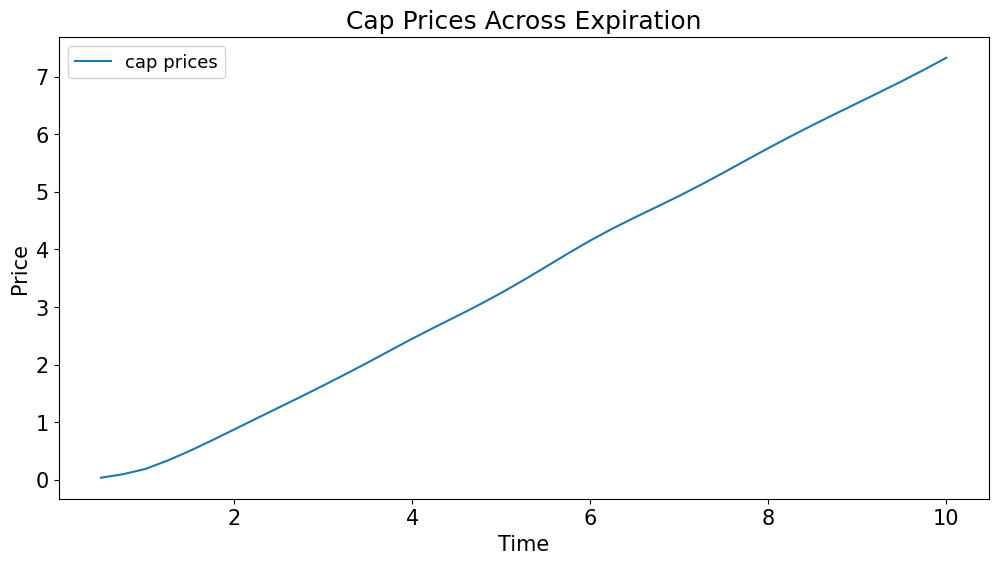

In [7]:
# plot the cap prices
capcurves[['cap prices']].plot(xlabel='Time',ylabel='Price',title='Cap Prices Across Expiration');

## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [8]:
# list the caplet prices
capcurves[['caplet prices']]

,caplet prices
tenor,
0.25,NaN
0.50,0.034285
0.75,0.061272
1.00,0.091266
1.25,0.146312
1.50,0.168763
1.75,0.182799
2.00,0.189741
2.25,0.190485


In [9]:
# list and compare forward volatility and flat volatility
capcurves[['fwd vols', 'flat vols']]

,fwd vols,flat vols
tenor,,
0.25,NaN,NaN
0.50,0.164498,0.164498
0.75,0.244029,0.189530
1.00,0.327210,0.214562
1.25,0.518534,0.257098
1.50,0.541362,0.288577
1.75,0.544506,0.310668
2.00,0.525341,0.325038
2.25,0.534827,0.333356


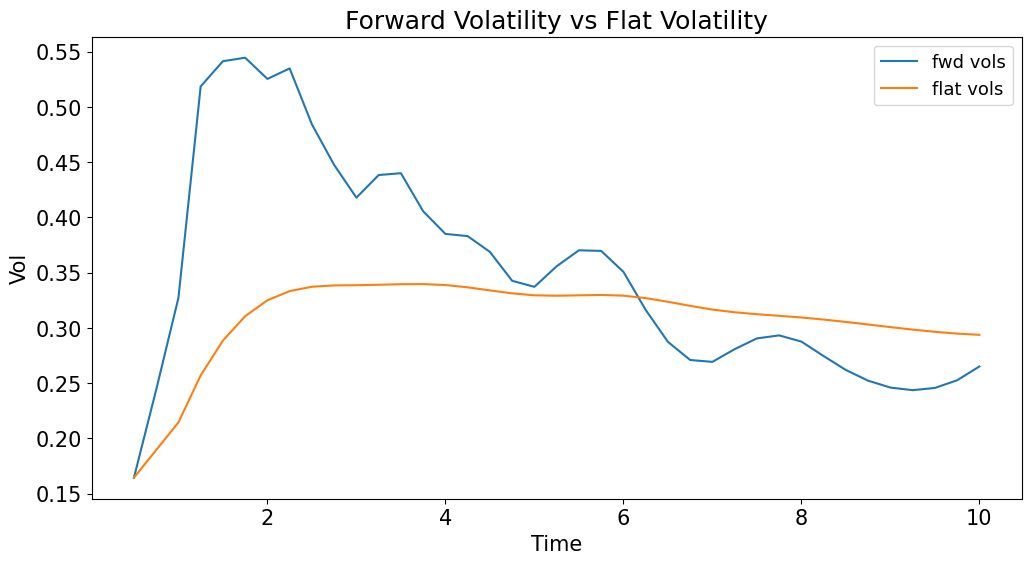

In [10]:
# plot the forward volatility versus flat volatility
capcurves[['fwd vols', 'flat vols']].plot(xlabel='Time',ylabel='Vol',title='Forward Volatility vs Flat Volatility');

## 1.3 Calibrate a BDT model 

Use data from the file `data/cap_curves_2024-02-16.xlsx` to calibrate the BDT model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
* You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.    

Given these volatility parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

**Display**
* the series of $\theta$ parameters.
* the tree of rates from $0\le t \le 10$.

In [11]:
# zero-coupon bond prices
quotes = curves['discounts'] * 100

sigmas = capcurves['fwd vols']
# assume sigma_0.25 is same as sigma_0.5
sigmas.iloc[0] = sigmas.iloc[1]


In [12]:
def construct_rate_tree(dt,T):
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree

In [13]:
def payoff_bond(r,dt,facevalue=100):
    price = np.exp(-r * dt) * facevalue
    return price

In [14]:
def rates_to_BDTstates(ratetree):
    ztree = np.log(100*ratetree)
    return ztree


In [15]:
def BDTstates_to_rates(ztree):
    ratetree = np.exp(ztree)/100
    return ratetree


In [16]:
def incrementBDTtree(ratetree, theta, sigma, dt=None):
    if dt is None:
        dt = ratetree.columns[1] - ratetree.columns[0]

    tstep = len(ratetree.columns)-1
    
    ztree = rates_to_BDTstates(ratetree)
    ztree.iloc[:,-1] = ztree.iloc[:,-2] + theta * dt + sigma * np.sqrt(dt)
    ztree.iloc[-1,-1] = ztree.iloc[-2,-2] + theta * dt - sigma * np.sqrt(dt)
    
    newtree = BDTstates_to_rates(ztree)
    return newtree

In [17]:
def bintree_pricing(payoff=None, ratetree=None, undertree=None,cftree=None, dt=None, pstars=None, timing=None, cfdelay=False,style='european',Tamerican=0):
    
    if payoff is None:
        payoff = lambda r: 0
    
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if dt is None:
        dt = undertree.columns.to_series().diff().mean()
        dt = undertree.columns[1]-undertree.columns[0]
    
    if timing == 'deferred':
        cfdelay = True
    
    if dt<.25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')
        
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back]
                
                if cfdelay:
                    cf = cftree.loc[state,t]
                else:                    
                    cf = cftree.iloc[state,-steps_back]
                
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (val_avg + cf)

            if style=='american':
                if t>= Tamerican:
                    valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]))
        
    return valuetree


In [18]:
def incremental_BDT_pricing(tree, theta, sigma_new, dt=None):
    if dt==None:
        dt = tree.columns[1] - tree.columns[0]
    
    payoff = lambda r: payoff_bond(r,dt)
    newtree = incrementBDTtree(tree, theta, sigma_new)
    model_price = bintree_pricing(payoff, newtree)
    return model_price


In [19]:
def estimate_theta(sigmas,quotes_zeros,dt=None,T=None):
    if dt is None:
        dt = quotes_zeros.index[1] - quotes_zeros.index[0]

    if T is None:
        T = quotes_zeros.index[-2]

    if quotes_zeros.mean() < 1:
        scale = 1
    else:
        scale = 100
        
    ratetree = construct_rate_tree(dt,T)
    theta = pd.Series(dtype=float, index=ratetree.columns, name='theta')
    dt = ratetree.columns[1] - ratetree.columns[0]
    
    if type(sigmas) is float:
        sigmas = pd.Series(sigmas,index=theta.index)

    for tsteps, t in enumerate(quotes_zeros.index):
        if tsteps==0:
            ratetree.loc[0,0] = -np.log(quotes_zeros.iloc[tsteps]/scale)/dt
        else:
            subtree = ratetree.iloc[:tsteps+1,:tsteps+1]
            wrapper = lambda theta: incremental_BDT_pricing(subtree, theta, sigmas.iloc[tsteps]).loc[0,0] - quotes_zeros.iloc[tsteps] * 100 / scale
            
            theta.iloc[tsteps] = fsolve(wrapper,.5)[0]
            ratetree.iloc[:tsteps+1,tsteps] = incrementBDTtree(subtree, theta.iloc[tsteps], sigmas.iloc[tsteps]).iloc[:,tsteps]
            
            #print(f'Completed: {tsteps/len(quotes_zeros.index):.1%}')
            
    return theta, ratetree


In [20]:
theta, ratetree = estimate_theta(sigmas, quotes)

In [21]:
theta

time
0.00         NaN
0.25   -0.111841
0.50   -0.296156
0.75   -0.441703
1.00   -0.960327
1.25   -0.643725
1.50   -0.544440
1.75   -0.384618
2.00   -0.495865
2.25   -0.090169
2.50    0.001702
2.75    0.119250
3.00   -0.121462
3.25   -0.008339
3.50    0.270192
3.75    0.210840
4.00    0.056486
4.25    0.190942
4.50    0.399952
4.75    0.350503
5.00    0.201865
5.25    0.150211
5.50    0.156079
5.75    0.201993
6.00    0.277209
6.25    0.321956
6.50    0.335453
6.75    0.318410
7.00    0.276073
7.25    0.245767
7.50    0.232141
7.75    0.235752
8.00    0.254116
8.25    0.269210
8.50    0.277749
8.75    0.279512
9.00    0.273698
9.25    0.259446
9.50    0.235780
9.75    0.201532
Name: theta, dtype: float64

In [22]:
def format_bintree(df,style='{:.2f}'):
    return df.style.format(style,na_rep='').format_index('{:.2f}',axis=1)

In [23]:
# display theta
format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
theta,,-11.18%,-29.62%,-44.17%,-96.03%,-64.37%,-54.44%,-38.46%,-49.59%,-9.02%,0.17%,11.93%,-12.15%,-0.83%,27.02%,21.08%,5.65%,19.09%,40.00%,35.05%,20.19%,15.02%,15.61%,20.20%,27.72%,32.20%,33.55%,31.84%,27.61%,24.58%,23.21%,23.58%,25.41%,26.92%,27.77%,27.95%,27.37%,25.94%,23.58%,20.15%


In [24]:
# diplay rate tree
format_bintree(ratetree,style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.29%,5.58%,5.86%,6.18%,6.30%,7.03%,8.05%,9.51%,10.98%,13.67%,17.11%,21.72%,26.23%,32.62%,42.75%,54.63%,67.10%,84.64%,111.02%,143.44%,180.24%,225.20%,281.71%,353.12%,443.32%,554.75%,690.82%,855.89%,1055.30%,1297.62%,1592.35%,1950.30%,2384.03%,2906.86%,3534.83%,4286.97%,5185.45%,6256.26%,7529.75%,9041.48%
1,,4.74%,4.97%,5.24%,5.34%,5.96%,6.83%,8.07%,9.31%,11.60%,14.51%,18.43%,22.25%,27.67%,36.26%,46.34%,56.92%,71.80%,94.18%,121.69%,152.90%,191.04%,238.98%,299.55%,376.08%,470.60%,586.04%,726.07%,895.23%,1100.80%,1350.82%,1654.48%,2022.42%,2465.95%,2998.67%,3636.72%,4398.92%,5307.30%,6387.64%,7670.06%
2,,,3.89%,4.10%,4.18%,4.67%,5.35%,6.32%,7.30%,9.09%,11.37%,14.44%,17.44%,21.68%,28.41%,36.31%,44.60%,56.25%,73.79%,95.34%,119.80%,149.68%,187.23%,234.69%,294.64%,368.70%,459.14%,568.85%,701.38%,862.44%,1058.32%,1296.23%,1584.50%,1931.98%,2349.35%,2849.24%,3446.40%,4158.09%,5004.49%,6009.23%
3,,,,2.96%,3.02%,3.37%,3.86%,4.56%,5.26%,6.55%,8.20%,10.41%,12.57%,15.63%,20.48%,26.18%,32.15%,40.55%,53.19%,68.73%,86.36%,107.91%,134.98%,169.20%,212.42%,265.81%,331.01%,410.10%,505.65%,621.76%,762.98%,934.49%,1142.31%,1392.83%,1693.72%,2054.11%,2484.62%,2997.70%,3607.90%,4332.25%
4,,,,,1.80%,2.00%,2.30%,2.71%,3.13%,3.90%,4.88%,6.20%,7.48%,9.31%,12.19%,15.58%,19.14%,24.15%,31.67%,40.92%,51.42%,64.25%,80.37%,100.74%,126.47%,158.26%,197.08%,244.17%,301.06%,370.19%,454.27%,556.39%,680.13%,829.28%,1008.43%,1223.00%,1479.33%,1784.81%,2148.12%,2579.39%
5,,,,,,1.17%,1.34%,1.58%,1.82%,2.27%,2.84%,3.61%,4.36%,5.42%,7.10%,9.07%,11.14%,14.05%,18.43%,23.81%,29.92%,37.39%,46.77%,58.62%,73.60%,92.10%,114.69%,142.10%,175.20%,215.43%,264.37%,323.79%,395.80%,482.60%,586.86%,711.73%,860.90%,1038.68%,1250.11%,1501.09%
6,,,,,,,0.78%,0.92%,1.06%,1.32%,1.65%,2.09%,2.53%,3.14%,4.12%,5.26%,6.46%,8.15%,10.69%,13.82%,17.36%,21.69%,27.13%,34.01%,42.70%,53.43%,66.54%,82.43%,101.64%,124.98%,153.37%,187.84%,229.62%,279.97%,340.45%,412.90%,499.43%,602.57%,725.22%,870.82%
7,,,,,,,,0.54%,0.63%,0.78%,0.97%,1.24%,1.49%,1.86%,2.43%,3.11%,3.82%,4.82%,6.32%,8.17%,10.27%,12.83%,16.05%,20.11%,25.25%,31.60%,39.35%,48.75%,60.11%,73.91%,90.69%,111.08%,135.78%,165.56%,201.33%,244.17%,295.34%,356.33%,428.86%,514.96%
8,,,,,,,,,0.37%,0.46%,0.57%,0.72%,0.88%,1.09%,1.43%,1.82%,2.24%,2.82%,3.70%,4.79%,6.01%,7.51%,9.40%,11.78%,14.79%,18.51%,23.05%,28.56%,35.21%,43.29%,53.13%,65.07%,79.54%,96.98%,117.93%,143.03%,173.00%,208.73%,251.22%,301.65%


***

# 2. Pricing a Callable Bond with BDT

## Freddie Mac

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `COZD1131782`, CUSIP `3134H1TN3`.
* Issued 2024-02-16
* Matures 2034-02-21
* Semiannual coupons
* Coupon rate 6.00%

Note that these bonds are not a niche market. Just this particular bond was issued with \$15 billion face value.

## 2.1 Price the Freddie Mac Bond


Assume today is `2024-02-16`.
* The market price on this day is `$99.953`.
* Approximate the TTM (time-to-maturity) to be exactly 10 years.

Price this bond using the model calibrated from  data.
* Price it with the BDT model calibrated in the previous problem.
* Note that the coupons are paid semiannually whereas the tree steps are quarterly.

Report the tree of bond prices, emphasizing the current modeled price.

How does our modeled price compare to the market price?

#### Bond Parameters

In [25]:
FACE = 100
# assume time to maturity is 10 years
T=10
# tree step interval
compound = 4
# coupon rate
cpn = .06
# coupon payment frequency
cpn_freq = 2

dt = 1/compound
tsteps = int(T/dt)

In [26]:
wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=FACE * (1+cpn/cpn_freq))

### The bond value and clean price trees are constructed as below:

In [27]:
def construct_bond_cftree(T, compound, cpn, cpn_freq=2, face=100):
    step = int(compound/cpn_freq)

    cftree = construct_rate_tree(1/compound, T)
    cftree.iloc[:,:] = 0
    cftree.iloc[:, -1:0:-step] = (cpn/cpn_freq) * face
    
    # final cashflow is accounted for in payoff function
    # drop final period cashflow from cashflow tree
    cftree = cftree.iloc[:-1,:-1]
    
    return cftree

In [28]:
cftree = construct_bond_cftree(T, compound, cpn)
# cash flow
cftree

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
1,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
2,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
3,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
4,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
5,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
6,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
7,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0
8,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,...,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0


In [29]:
# bond price tree
# it is dirty price
# the rate tree from last question
bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
format_bintree(bondtree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,111.87,103.58,97.71,88.36,81.46,71.30,63.99,53.79,46.77,37.32,31.51,23.63,19.53,13.49,11.29,7.13,6.39,3.51,3.71,1.71,2.29,0.79,1.40,0.29,0.78,0.08,0.36,0.01,0.12,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,124.53,117.30,112.50,104.11,98.05,88.51,81.51,71.27,63.80,53.47,46.39,36.90,30.94,22.89,18.74,12.75,10.46,6.29,5.57,2.89,3.09,1.26,1.78,0.49,1.00,0.15,0.50,0.03,0.19,0.00,0.05,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2,,,128.72,125.04,117.84,112.97,104.55,98.55,89.08,82.10,71.88,64.50,54.25,47.09,37.42,31.39,23.33,18.95,12.75,10.34,6.21,5.39,2.71,2.79,1.05,1.49,0.35,0.78,0.09,0.35,0.01,0.12,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,134.90,128.83,125.19,118.05,113.36,105.16,99.34,90.08,83.40,73.49,66.25,56.01,48.96,39.41,33.21,24.87,20.32,14.04,11.37,6.98,5.85,3.00,2.89,1.12,1.44,0.36,0.70,0.09,0.30,0.01,0.09,0.00,0.02,0.00,0.00,0.00,0.00
4,,,,,136.98,134.41,128.44,125.03,118.17,113.76,105.88,100.50,91.71,85.42,75.78,68.95,59.12,52.22,42.63,36.49,28.21,23.48,16.81,13.71,8.85,7.32,4.09,3.71,1.66,1.85,0.58,0.91,0.16,0.41,0.03,0.15,0.00,0.04,0.01,0.16
5,,,,,,140.79,135.73,133.34,127.60,124.43,117.86,113.85,106.42,101.47,93.07,87.30,78.25,71.83,62.30,55.80,46.63,40.68,32.33,27.40,20.42,16.95,11.65,9.70,5.98,5.21,2.74,2.69,1.12,1.37,0.41,0.67,0.17,0.36,0.31,2.42
6,,,,,,,140.67,139.03,134.13,131.93,126.42,123.56,117.34,113.70,106.64,102.18,94.36,89.09,80.49,74.67,65.81,59.83,51.00,45.28,37.03,32.13,25.03,21.35,15.69,13.33,9.11,7.93,4.99,4.65,2.72,2.88,1.81,2.49,3.27,11.68
7,,,,,,,,142.86,138.56,137.05,132.31,130.32,125.06,122.48,116.56,113.30,106.71,102.71,95.35,90.67,82.78,77.62,69.33,63.89,55.56,50.29,42.41,37.77,30.79,27.12,21.33,18.82,14.38,13.06,10.00,9.84,8.39,10.13,13.16,28.43
8,,,,,,,,,141.55,140.51,136.32,134.95,130.38,128.58,123.54,121.23,115.66,112.76,106.56,103.06,96.31,92.25,84.97,80.44,72.81,68.07,60.43,55.82,48.54,44.44,37.91,34.69,29.31,27.32,23.51,23.24,21.85,24.97,30.20,48.45


In [30]:
def construct_accint(timenodes, freq, cpn, cpn_freq=2, face=100):

    mod = freq/cpn_freq
    cpn_pmnt = face * cpn/cpn_freq

    temp = np.arange(len(timenodes)) % mod
    # shift to ensure end is considered coupon (not necessarily start)
    temp = (temp - temp[-1] - 1) % mod
    temp = cpn_pmnt * temp.astype(float)/mod

    accint = pd.Series(temp,index=timenodes)

    return accint


In [31]:
# compute accrued interest in each time node between coupon payment
accint = construct_accint(bondtree.columns.values, compound, cpn)
accint_df = pd.DataFrame(accint)
accint_df.rename(columns={0:'accrued interest amount'})

,accrued interest amount
0.00,0.0
0.25,1.5
0.50,0.0
0.75,1.5
1.00,0.0
1.25,1.5
1.50,0.0
1.75,1.5
2.00,0.0
2.25,1.5


In [32]:
# calculate for the clean price by subtract the accrued interest
# only node at 0.25, 0.75... will subtract the accrued interest 
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)
format_bintree(cleantree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,110.37,103.58,96.21,88.36,79.96,71.30,62.49,53.79,45.27,37.32,30.01,23.63,18.03,13.49,9.79,7.13,4.89,3.51,2.21,1.71,0.79,0.79,0.00,0.29,0.00,0.08,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,123.03,117.30,111.00,104.11,96.55,88.51,80.01,71.27,62.30,53.47,44.89,36.90,29.44,22.89,17.24,12.75,8.96,6.29,4.07,2.89,1.59,1.26,0.28,0.49,0.00,0.15,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,128.72,123.54,117.84,111.47,104.55,97.05,89.08,80.60,71.88,63.00,54.25,45.59,37.42,29.89,23.33,17.45,12.75,8.84,6.21,3.89,2.71,1.29,1.05,0.00,0.35,0.00,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,133.40,128.83,123.69,118.05,111.86,105.16,97.84,90.08,81.90,73.49,64.75,56.01,47.46,39.41,31.71,24.87,18.82,14.04,9.87,6.98,4.35,3.00,1.39,1.12,0.00,0.36,0.00,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,136.98,132.91,128.44,123.53,118.17,112.26,105.88,99.00,91.71,83.92,75.78,67.45,59.12,50.72,42.63,34.99,28.21,21.98,16.81,12.21,8.85,5.82,4.09,2.21,1.66,0.35,0.58,0.00,0.16,0.00,0.03,0.00,0.00,0.00,0.01,0.00
5,,,,,,139.29,135.73,131.84,127.60,122.93,117.86,112.35,106.42,99.97,93.07,85.80,78.25,70.33,62.30,54.30,46.63,39.18,32.33,25.90,20.42,15.45,11.65,8.20,5.98,3.71,2.74,1.19,1.12,0.00,0.41,0.00,0.17,0.00,0.31,0.92
6,,,,,,,140.67,137.53,134.13,130.43,126.42,122.06,117.34,112.20,106.64,100.68,94.36,87.59,80.49,73.17,65.81,58.33,51.00,43.78,37.03,30.63,25.03,19.85,15.69,11.83,9.11,6.43,4.99,3.15,2.72,1.38,1.81,0.99,3.27,10.18
7,,,,,,,,141.36,138.56,135.55,132.31,128.82,125.06,120.98,116.56,111.80,106.71,101.21,95.35,89.17,82.78,76.12,69.33,62.39,55.56,48.79,42.41,36.27,30.79,25.62,21.33,17.32,14.38,11.56,10.00,8.34,8.39,8.63,13.16,26.93
8,,,,,,,,,141.55,139.01,136.32,133.45,130.38,127.08,123.54,119.73,115.66,111.26,106.56,101.56,96.31,90.75,84.97,78.94,72.81,66.57,60.43,54.32,48.54,42.94,37.91,33.19,29.31,25.82,23.51,21.74,21.85,23.47,30.20,46.95


**Comment: Considerable differences can be observed between the modeled price and market price (99.95 v. 116.65). The modeled price is much higher than the market quote price.**

## 2.2 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

#### Style
* (approximately) American style
* called only on quarterly dates, not any date
* since our tree is quarterly, this means callable on any date on our tree.

#### Strike
* Strike is 100.
* The strike is based on the **clean** price of the bond, meaning the price which does not account for accrued interest.
    * In pricing the bond in the previous problem, you should have considered the accrued coupons, or dirty prices.
    * But in analyzing the option, you must consider its moneyness and payoff based on the clean price.

### Pricing
Use the BDT model to price this implicit American call option and the resulting callable bond.
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now that you are accounting for the short embedded option? 

Does the price of the callable bond ever get above \$100?

In [33]:
STRIKE = 100
CLEANCALL = True

In [34]:
payoff_call = lambda p: np.maximum(p-STRIKE,0)

In [35]:
if CLEANCALL:
    undertree = cleantree
else:
    undertree = bondtree


# american style
# it is the call price tree
# undertree is clean price tree as CLEANCALL is set to be True
calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= undertree, style='american')
format_bintree(calltree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,19.07,15.06,11.52,8.51,6.06,4.15,2.73,1.72,1.03,0.59,0.31,0.16,0.07,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,23.59,19.02,14.88,11.22,8.16,5.72,3.85,2.49,1.53,0.90,0.50,0.26,0.12,0.05,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,28.72,23.64,18.94,14.58,10.84,7.79,5.37,3.56,2.26,1.37,0.78,0.42,0.21,0.10,0.04,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,33.40,28.83,23.69,18.67,14.18,10.45,7.39,5.02,3.28,2.05,1.21,0.68,0.36,0.17,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,36.98,32.91,28.44,23.53,18.22,13.80,10.00,6.97,4.68,3.01,1.85,1.07,0.59,0.30,0.14,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,,,,,,39.29,35.73,31.84,27.60,22.93,17.86,13.29,9.47,6.52,4.32,2.73,1.64,0.93,0.49,0.24,0.11,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,,,,,,,40.67,37.53,34.13,30.43,26.42,22.06,17.34,12.63,8.90,6.07,3.95,2.45,1.44,0.79,0.41,0.19,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,,,,,,,,41.36,38.56,35.55,32.31,28.82,25.06,20.98,16.56,11.91,8.34,5.58,3.56,2.16,1.24,0.66,0.32,0.14,0.05,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,,,,,,,,,41.55,39.01,36.32,33.45,30.38,27.08,23.54,19.73,15.66,11.26,7.74,5.08,3.17,1.88,1.04,0.53,0.24,0.10,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [36]:
# this the quote clean price
QUOTE_CALLABLE_CLEAN = 99.953
num_accrued = int((T*compound) %cpn_freq)
# this is the dirty price
quote_callable_dirty = QUOTE_CALLABLE_CLEAN + num_accrued * (cpn/compound)*FACE


In [37]:
# first consider the dirty bond price tree
callablebondtree = bondtree - calltree
model_price_dirty = callablebondtree.iloc[0,0]
model_price_clean = model_price_dirty - accint.iloc[0]

In [38]:
print(f'Modeled price will be {model_price_clean}')

Modeled price will be 97.5744516527338


In [39]:
# also we can directly use the clean tree
callablecleanbondtree = cleantree - calltree
callablecleanbondtree
format_bintree(callablecleanbondtree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,97.57,95.31,92.05,87.71,82.30,75.81,68.57,60.77,52.76,44.68,37.01,29.85,23.56,18.00,13.48,9.78,7.13,4.89,3.51,2.21,1.71,0.79,0.79,0.00,0.29,0.00,0.08,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,99.44,98.28,96.11,92.89,88.40,82.78,76.16,68.78,60.77,52.57,44.39,36.64,29.31,22.84,17.22,12.75,8.96,6.29,4.07,2.89,1.59,1.26,0.28,0.49,0.00,0.15,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,100.00,99.91,98.90,96.89,93.71,89.26,83.71,77.04,69.62,61.64,53.47,45.17,37.21,29.79,23.28,17.43,12.74,8.84,6.21,3.89,2.71,1.29,1.05,0.00,0.35,0.00,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,100.00,100.00,100.00,99.38,97.69,94.70,90.45,85.07,78.62,71.44,63.54,55.33,47.10,39.24,31.63,24.84,18.81,14.04,9.87,6.98,4.35,3.00,1.39,1.12,0.00,0.36,0.00,0.09,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,100.00,100.00,100.00,100.00,99.94,98.46,95.87,92.03,87.03,80.90,73.93,66.37,58.54,50.42,42.49,34.93,28.19,21.97,16.81,12.21,8.85,5.82,4.09,2.21,1.66,0.35,0.58,0.00,0.16,0.00,0.03,0.00,0.00,0.00,0.01,0.00
5,,,,,,100.00,100.00,100.00,100.00,100.00,100.00,99.07,96.95,93.45,88.75,83.07,76.60,69.39,61.80,54.06,46.53,39.14,32.31,25.90,20.41,15.45,11.65,8.20,5.98,3.71,2.74,1.19,1.12,0.00,0.41,0.00,0.17,0.00,0.31,0.92
6,,,,,,,100.00,100.00,100.00,100.00,100.00,100.00,100.00,99.57,97.74,94.62,90.41,85.14,79.06,72.38,65.40,58.14,50.93,43.75,37.03,30.63,25.03,19.85,15.69,11.83,9.11,6.43,4.99,3.15,2.72,1.38,1.81,0.99,3.27,10.18
7,,,,,,,,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,99.89,98.37,95.63,91.79,87.02,81.55,75.46,69.01,62.25,55.50,48.77,42.41,36.27,30.79,25.62,21.33,17.32,14.38,11.56,10.00,8.34,8.39,8.63,13.16,26.93
8,,,,,,,,,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,98.82,96.48,93.14,88.88,83.93,78.41,72.57,66.47,60.39,54.31,48.54,42.94,37.91,33.19,29.31,25.82,23.51,21.74,21.85,23.47,30.20,46.95


In [40]:
prices = pd.DataFrame({'clean':[QUOTE_CALLABLE_CLEAN, model_price_clean], 'dirty':[quote_callable_dirty, model_price_dirty]}, index=['market quote','model'])
# show the price of the bond embedding call option
prices.style.format('{:.2f}')

,clean,dirty
market quote,99.95,99.95
model,97.57,97.57


**Comment: The differences between the modeled price and the market price is $2.38; the modeled price gets much smaller as we consider the callable component (as there is a huge benefit for the issuer to early exercise), it becomes lower than the market quote.**

### The times its price goes over 100

In [41]:
callablebondtree.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,
0,97.574452,96.806729,92.052890,89.208198,82.297672,77.308855,68.573050,62.272052,52.757106,46.183820,...,0.000661,0.022888,0.000011,0.002094,2.935593e-08,0.000066,6.644242e-12,4.835912e-07,1.669862e-15,1.571004e-08
1,NaN,100.938646,98.281332,97.612817,92.894883,89.897595,82.784514,77.662325,68.783314,62.265833,...,0.002829,0.047960,0.000096,0.006306,7.648433e-07,0.000338,8.115485e-10,5.185473e-06,1.814937e-12,4.843631e-07
2,NaN,NaN,100.000000,101.406350,98.904679,98.389459,93.709818,90.757894,83.705642,78.540663,...,0.014768,0.117727,0.001111,0.023965,2.825938e-05,0.002419,1.596422e-07,9.173489e-05,3.811429e-09,3.078934e-05
3,NaN,NaN,NaN,101.500000,100.000000,101.500000,99.379800,99.185671,94.700966,91.951824,...,0.089391,0.298584,0.014319,0.092754,1.178623e-03,0.017671,3.822450e-05,1.670496e-03,9.987193e-06,2.037801e-03
4,NaN,NaN,NaN,NaN,100.000000,101.500000,100.000000,101.500000,99.942962,99.956830,...,0.578070,0.905673,0.161690,0.405208,3.286682e-02,0.145012,4.871653e-03,3.643754e-02,5.999295e-03,1.630437e-01


In [42]:
compare_with = 100
# first check the dirty price tree
print(f'Considering dirty price, there are {(callablebondtree > compare_with).sum().sum()} points in our tree where it goes above {compare_with}.')

Considering dirty price, there are 235 points in our tree where it goes above 100.


In [43]:
# then check the clean price tree
print(f'Considering clean price, there are {(callablecleanbondtree > compare_with).sum().sum()} points in our tree where it goes above {compare_with}.')

Considering clean price, there are 0 points in our tree where it goes above 100.


**Comment: Therefore, as we are using clean price to determine the payoff, we should use the clean price tree, which includes no point exceeding $100. The price of the callable bond will not get above $100 indeed, the issuer will exercise the option and redeem the bond when the price is above $100.**

## 2.3 Exercising the Option

Show a heatmap of the nodes in which the American bond is exercised.

Is it exercised every time it is in-the-money?

In [44]:
def exercise_decisions(payoff, undertree, derivtree):
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer

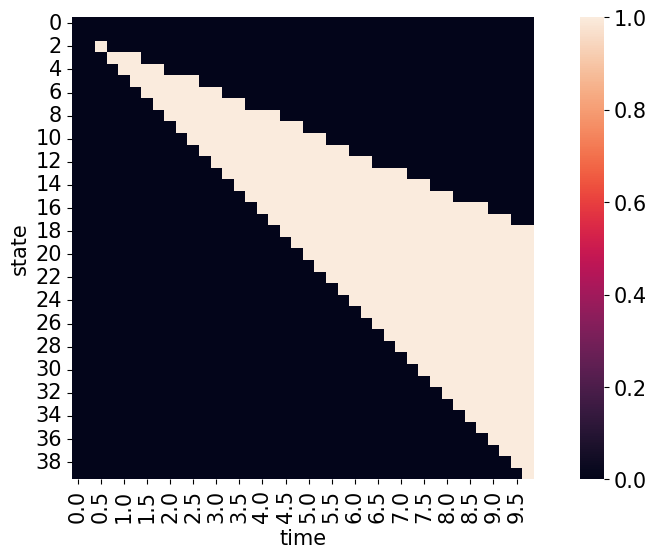

In [45]:
# show the heatmap when the American bond is exercised
sns.heatmap(exercise_decisions(payoff_call,undertree,calltree),square=True);

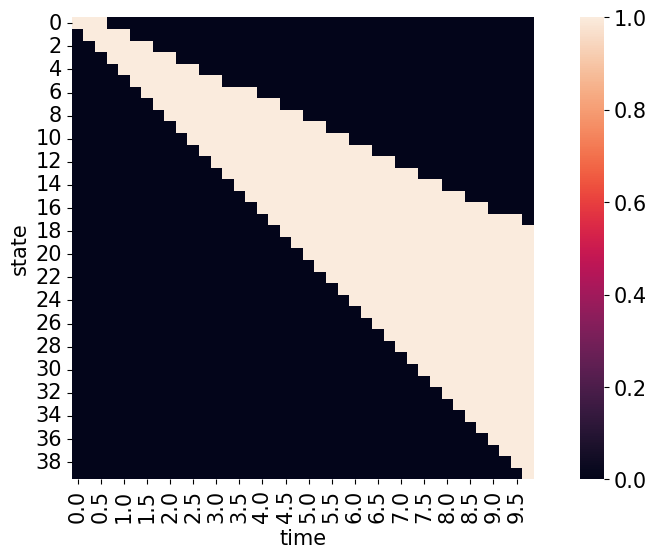

In [46]:
# in the money
sns.heatmap(undertree > STRIKE, square=True);

In [47]:
# compare two heatmaps
exercise_decisions(payoff_call,undertree,calltree) == (undertree > STRIKE)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,False,False,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,False,False,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,False,False,False,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,False,False,...,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


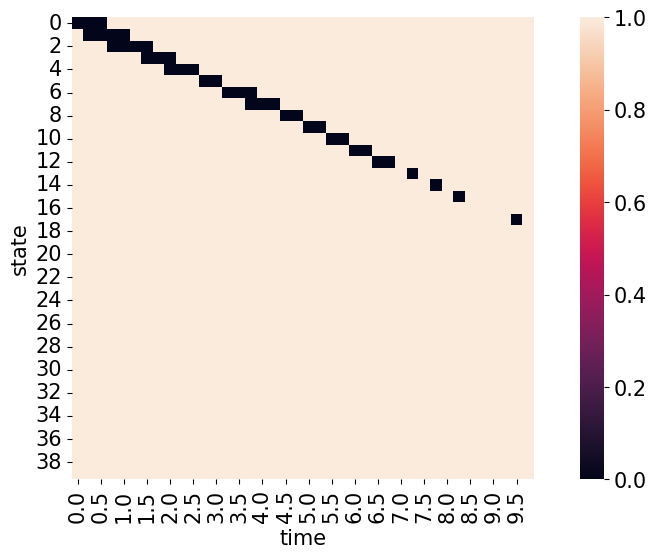

In [48]:
# heatmap of the comparison
sns.heatmap(exercise_decisions(payoff_call,undertree,calltree) == (undertree > STRIKE), square=True);

**Comment: NO, there are sometime (black parts in the comparison heatmap above) when the bond is in-the-money, the decision is NOT to exercise.**

***

# 3. Option Adjusted Spread

*This section is optional. No need to submit it, but we will likely discuss it in class.*

## 3.1 Calculate the OAS

The **option adjusted spread** is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond? 

* Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.) 

* Use the parallel shifts to recalibrate the $\theta$ parameters in the BDT tree. 

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

#### Note:
This **OAS** is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

## 3.2 Convexity

Continue with parallel shifts of the (present, market quoted) yield curve. 
* Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
* Do you see convexity in this relationship?

***